<a href="https://colab.research.google.com/github/shinebalance/DL_notes/blob/master/DeepLearningwithPython/5_2_CNNinAction(tf2_0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **(TF2.0学習)5_2 実践CNNほか**  
---

## Purpose
* 「Deep learning with Python」5章の内容をTF2.0のsubclassingで整理して学習するnotebook 

## Abstract
 2. 実践CNN,前処理とDataAugmentation(5.2)  

## Note
* Data Augmentationは以下でやる
> https://www.tensorflow.org/tutorials/images/data_augmentation

## ベースにしたKerasコード
> https://github.com/fchollet/deep-learning-with-python-notebooks

---


# Kerasのインポート

In [1]:
# 2.0をColabで実行する際に必要らしい
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

# enable eager execution...2.0が導入できていればDefaultでEnable
# tf.enable_eager_execution()
print(tf.executing_eagerly())

2.2.0-rc2
True


---

# 2) 実践CNN,前処理とDataAugmentation(5.2)  

## 使用データの準備
https://www.kaggle.com/c/dogs-vs-cats/data
* Kaggle APIからデータを取得する。
* 自分のアカウントのkaggle.jsonトークンを読み込んで利用する。

In [0]:
from google.colab import files
files.upload()#初回は「ファイル選択」が実行できずエラーになることが有るので、何度か実行してみること

In [0]:
# ディレクトリ状況確認
!ls
# Kaggleデータセット保管用のディレクトリを作成
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Kaggleモジュールをinstall
# !pip install kaggle

In [0]:
# アクセスパーミッション付加
!chmod 600 /root/.kaggle/kaggle.json
# 今回のcatVSdogデータセットを取得(URL:https://www.kaggle.com/c/dogs-vs-cats/discussion)
# 稀に404エラーが出る場合があり、その場合はセッションごと再起動が推奨
!kaggle competitions download -c dogs-vs-cats
# zipの解凍
!unzip -oq train.zip -d ./dogs-vs-cats

In [0]:
# 解凍結果の確認
!ls ./dogs-vs-cats/train | head -10
# データ数
!ls -1 ./dogs-vs-cats/train | wc -l



以上

---

## Dog vs Cat Datasetを使ったCNNの検証

### データセットの設定

In [0]:
import os, shutil

In [0]:
# 繰り返しなので関数化
def mkdirPerCase(base_dir, dir_name):
  _dir = os.path.join(base_dir, dir_name)
  os.mkdir(_dir)
  return _dir

In [8]:
base_dir = './cats_and_dogs_small'
os.mkdir(base_dir)

train_dir      = mkdirPerCase(base_dir,'train')
train_cats_dir = mkdirPerCase(base_dir,'train/cats')
train_dogs_dir = mkdirPerCase(base_dir,'train/dogs')

test_dir = mkdirPerCase(base_dir,'test')
test_cats_dir = mkdirPerCase(base_dir,'test/cats')
test_dogs_dir = mkdirPerCase(base_dir,'test/dogs')

validation_dir = mkdirPerCase(base_dir,'validation')
validation_cats_dir = mkdirPerCase(base_dir,'validation/cats')
validation_dogs_dir = mkdirPerCase(base_dir,'validation/dogs')

!ls ./cats_and_dogs_small

test  train  validation


In [0]:
'''実行可能を確認したら消す
# DLしたデータをリネームしてフォルダ分けする
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)
'''

In [0]:
# 指定ディレクトリにファイルをコピーする関数
def copyPerCase(original_dataset_dir, fname_list, dst_dir):
  for fname in fname_list:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(dst_dir, fname)
    shutil.copyfile(src, dst)

In [0]:
original_dataset_dir = './dogs-vs-cats/train'

# Copy first 1000 cat images to train_cats_dir
fname_list = ['cat.{}.jpg'.format(i) for i in range(1000)]
copyPerCase(original_dataset_dir, fname_list, train_cats_dir)
# Copy next 500 cat images to validation_cats_dir
fname_list = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
copyPerCase(original_dataset_dir, fname_list, validation_cats_dir)
# Copy next 500 cat images to test_cats_dir
fname_list = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
copyPerCase(original_dataset_dir, fname_list, test_cats_dir)
    
# Copy first 1000 dog images to train_dogs_dir
fname_list = ['dog.{}.jpg'.format(i) for i in range(1000)]
copyPerCase(original_dataset_dir, fname_list, train_dogs_dir)
# Copy next 500 dog images to validation_dogs_dir
fname_list = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
copyPerCase(original_dataset_dir, fname_list, validation_dogs_dir)
# Copy next 500 dog images to test_dogs_dir
fname_list = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
copyPerCase(original_dataset_dir, fname_list, test_dogs_dir)

In [0]:


'''
# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)
'''

In [12]:
# データ件数の確認
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [0]:
'''旧ログ、確認したら消す
# データ件数の確認
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))'''

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


> ToDO:このあたりのK-holdはtensorflowになにかメソッド無いのかしら

### 2-1)モデル構築(転移学習なし)
* CNNをデータセットで１から学習させるパターン

Subclassingで実装

In [0]:
class SimpleCNN(tf.keras.Model):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.cn1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')
        self.max1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.cn2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')
        self.max2 = tf.keras.layers.MaxPooling2D((2, 2))
        self.cn3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')
        self.max3 = tf.keras.layers.MaxPooling2D((2, 2))
        self.cn4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')
        self.max4 = tf.keras.layers.MaxPooling2D((2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, x, training=False):
        x = self.cn1(x)
        x = self.max1(x)
        x = self.cn2(x)
        x = self.max2(x)
        x = self.cn3(x)
        x = self.max3(x)
        x = self.cn4(x)
        x = self.max4(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

model = SimpleCNN()
model.build((None, 150, 150, 3))

In [0]:
'''
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

In [0]:
# Optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
# loss function
loss_object = tf.keras.losses.binary_crossentropy

# metric
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')

In [0]:
'''from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

W0815 23:53:09.610758 139908707583872 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0815 23:53:09.621171 139908707583872 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


※編集中

#### データ前処理

In [0]:
# リサイズ処理
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


#### 学習（転移学習なし）

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

W0812 14:23:50.009128 140513819547520 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/30
100/100 [==============================] - 17s 171ms/step - loss: 0.6890 - acc: 0.5475 - val_loss: 0.6654 - val_acc: 0.5950
Epoch 2/30
100/100 [==============================] - 8s 83ms/step - loss: 0.6555 - acc: 0.5995 - val_loss: 0.6382 - val_acc: 0.6400
Epoch 3/30
100/100 [==============================] - 8s 84ms/step - loss: 0.6101 - acc: 0.6720 - val_loss: 0.6279 - val_acc: 0.6350
Epoch 4/30
100/100 [==============================] - 8s 84ms/step - loss: 0.5724 - acc: 0.6980 - val_loss: 0.6170 - val_acc: 0.6500
Epoch 5/30
100/100 [==============================] - 8s 85ms/step - loss: 0.5463 - acc: 0.7215 - val_loss: 0.6224 - val_acc: 0.6480
Epoch 6/30
100/100 [==============================] - 8s 84ms/step - loss: 0.5132 - acc: 0.7425 - val_loss: 0.5793 - val_acc: 0.6950
Epoch 7/30
100/100 [==============================] - 9s 85ms/step - loss: 0.4917 - acc: 0.7495 - val_loss: 0.5994 - val_acc: 0.6810
Epoch 8/30
100/100 [==============================] - 8s 84ms/step 

#### 実行時間についてのメモ(@shinebalance)
* MacBookPro2016(Core i5 2.9Ghz) 　：5エポックで10分
* Google Colab with GPU　　　　　　：5エポックで1分


In [0]:
model.save('cats_and_dogs_small_1.h5')

#### 可視化

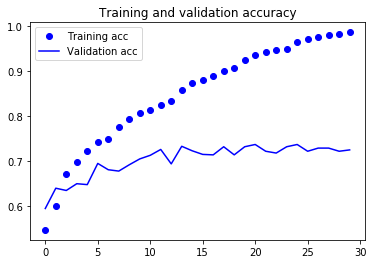

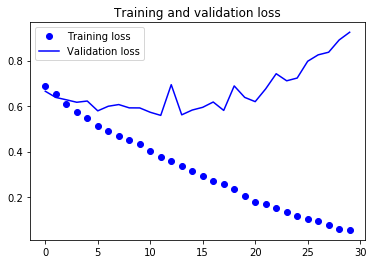

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 2-2)Data Augmentation（データ拡張）後のモデル構築

In [0]:
# 2-1)をスキップしている場合は以下コメントイン
# from keras.preprocessing.image import ImageDataGenerator
# import matplotlib.pyplot as plt

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

#### Data Augmentationの実行

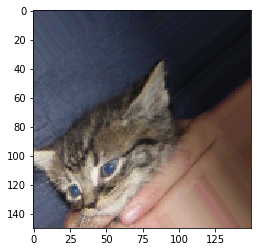

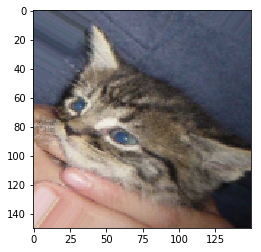

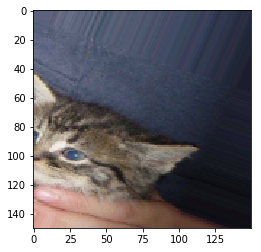

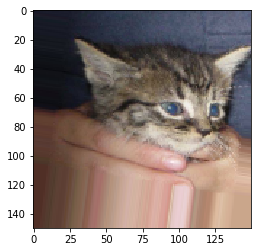

In [0]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

#### モデル構築(ドロップアウト層を含む）

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

W0815 23:53:51.336394 139908707583872 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

#### 学習
* **!本学習はデータ件数が多く、Google Colab(withGPU)でも1時間近く学習に時間がかかるため、自宅での実行を推奨する**

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 28s 282ms/step - loss: 0.6901 - acc: 0.5147 - val_loss: 0.6724 - val_acc: 0.6244
Epoch 2/100
100/100 [==============================] - 24s 239ms/step - loss: 0.6741 - acc: 0.5672 - val_loss: 0.6746 - val_acc: 0.5464
Epoch 3/100
100/100 [==============================] - 24s 236ms/step - loss: 0.6493 - acc: 0.6062 - val_loss: 0.6259 - val_acc: 0.6377
Epoch 4/100
100/100 [==============================] - 24s 240ms/step - loss: 0.6330 - acc: 0.6353 - val_loss: 0.6310 - val_acc: 0.6482
Epoch 5/100
100/100 [==============================] - 24s 237ms/step - loss: 0.6241 - acc: 0.6469 - val_loss: 0.6091 - val_acc: 0.6504
Epoch 6/100
100/100 [==============================] - 24s 236ms/step - loss: 0.6027 - acc: 0.6762 - val_loss: 0.5722 - val_acc: 0.7049
Epoch 7/100
100/100 [==============================] - 24s 239ms/step - loss: 0.5932 - acc: 0.6828 -

#### 可視化

In [0]:
model.save('cats_and_dogs_small_2.h5')

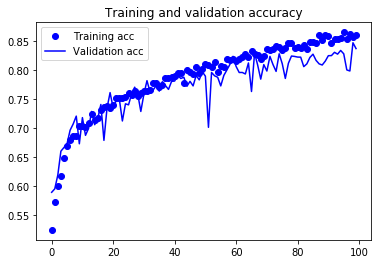

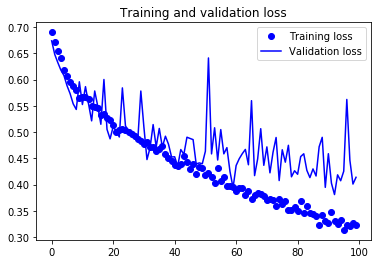

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()